In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.simulate import simulate_networks
from inv_vae.utils.helpers import Namespace, reset_weights
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [23]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

simulate data

In [2]:
n_nets = 1000
n_nodes = 68
p_in = .25
p_out = .01
n_noisy_nets = int(n_nets*.2)
noise_level = .6
noise_sd = .05

In [3]:
sim_nets, noisy_nets, noises, noise_ids = simulate_networks(n_nets=n_nets, n_nodes=n_nodes, p_in=p_in, p_out=p_out, seed=seed,
                                          n_noisy_nets=n_noisy_nets, noise_level=noise_level, noise_sd=noise_sd)
print(sim_nets.shape, noisy_nets.shape, noises.shape)

(1000, 68, 68) (1000, 68, 68) (1000,)


In [27]:
A_mat = np.mean(noisy_nets, axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i).float().to(config.device) for i in range(config.n_dec_layers)]

In [4]:
big_sim_nets = sim_nets[np.arange(n_noisy_nets)]
small_sim_nets = sim_nets[np.arange(n_noisy_nets, n_nets)]
diff_sim_nets = small_sim_nets.mean(0) - big_sim_nets.mean(0)

big_noise_nets = noisy_nets[np.arange(n_noisy_nets)]
small_noise_nets = noisy_nets[np.arange(n_noisy_nets, n_nets)]
diff_noise_nets = small_noise_nets.mean(0) - big_noise_nets.mean(0)

In [10]:
pca = PCA(2)
sim_Xt = pca.fit_transform(sim_nets.reshape(-1, n_nodes*n_nodes))
noisy_Xt = pca.fit_transform(noisy_nets.reshape(-1, n_nodes*n_nodes))
sim_df = pd.DataFrame({"pc1": sim_Xt[:,0], "pc2": sim_Xt[:,1], "noise": noises})
noisy_df = pd.DataFrame({"pc1": noisy_Xt[:,0], "pc2": noisy_Xt[:,1], "noise": noises})

prepare datasets for training

In [106]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .1, add_reg = False, y_dim = 0, 
    batch_size=32, n_epochs=200, lr=3e-6, device=DEVICE)

In [39]:
ids = list(range(n_nets))
random.shuffle(ids)
train_ids = ids[:int(.9*n_nets)]
val_ids = ids[int(.9*n_nets):]
print(len(train_ids), len(val_ids))
tensor_nets = torch.stack([torch.Tensor(i) for i in list(noisy_nets)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_noises = torch.from_numpy(noises).to(torch.float32).view(-1, 1)

train_set = utils.TensorDataset(tensor_nets[train_ids], 
                        tensor_noises[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], 
                        tensor_noises[val_ids] )

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

900 100


vae

In [107]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [108]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.custom_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.custom_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 4976.679 nll: 4975.915 kl: 7.637
epoch: 0 test loss 4431.567 nll: 4430.724 kl: 8.429
epoch: 5 train loss: 2970.954 nll: 2969.052 kl: 19.017
epoch: 5 test loss 2976.018 nll: 2974.230 kl: 17.885
epoch: 10 train loss: 2781.010 nll: 2779.427 kl: 15.829
epoch: 10 test loss 2810.873 nll: 2809.420 kl: 14.538
epoch: 15 train loss: 2737.086 nll: 2735.617 kl: 14.694
epoch: 15 test loss 2767.266 nll: 2765.889 kl: 13.772
epoch: 20 train loss: 2722.602 nll: 2720.980 kl: 16.221
epoch: 20 test loss 2751.715 nll: 2750.172 kl: 15.424
epoch: 25 train loss: 2716.515 nll: 2714.473 kl: 20.412
epoch: 25 test loss 2744.762 nll: 2742.830 kl: 19.321
epoch: 30 train loss: 2712.818 nll: 2710.228 kl: 25.899
epoch: 30 test loss 2740.947 nll: 2738.497 kl: 24.491
epoch: 35 train loss: 2710.222 nll: 2706.917 kl: 33.047
epoch: 35 test loss 2736.922 nll: 2733.810 kl: 31.119
epoch: 40 train loss: 2707.314 nll: 2703.283 kl: 40.312
epoch: 40 test loss 2734.099 nll: 2730.337 kl: 37.612
epoch: 45 train 

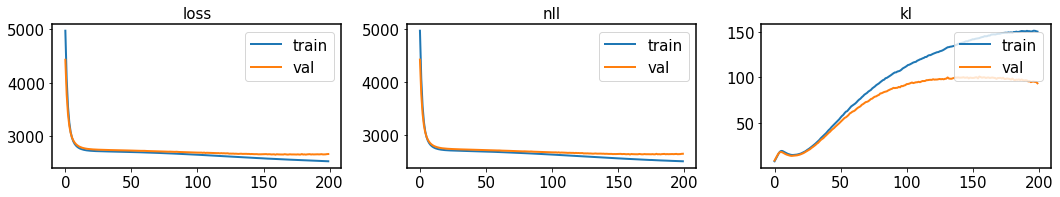

In [109]:
# diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)
plt.tight_layout()
plt.show()

In [110]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

In [111]:
big_noise_recon = x_recon[np.arange(n_noisy_nets)]
small_noise_recon = x_recon[np.arange(n_noisy_nets, n_nets)]
diff_noise_recon= small_noise_recon.mean(0) - big_noise_recon.mean(0)

In [112]:
pca = PCA(2)
vae_Xt = pca.fit_transform(vae_latents)
vae_df = pd.DataFrame({"pc1": vae_Xt[:,0], "pc2": vae_Xt[:,1], "noise": noises})

inv-vae

In [97]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=1,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = 1., gamma = .1, add_reg = False, y_dim = 0,               
    batch_size=32, n_epochs=200, lr=3e-6, device=DEVICE)

In [98]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [99]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.custom_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.custom_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 2818.941 nll: 5114.523 kl: 5.938 inv_loss: 0.151
epoch: 0 test loss 2469.993 nll: 4484.336 kl: 3.593 inv_loss: 0.148
epoch: 5 train loss: 1621.286 nll: 2945.181 kl: 1.428 inv_loss: 0.079
epoch: 5 test loss 1623.708 nll: 2949.771 kl: 1.325 inv_loss: 0.088
epoch: 10 train loss: 1525.330 nll: 2771.644 kl: 0.921 inv_loss: 0.052
epoch: 10 test loss 1541.009 nll: 2800.225 kl: 0.879 inv_loss: 0.059
epoch: 15 train loss: 1504.662 nll: 2734.632 kl: 0.611 inv_loss: 0.035
epoch: 15 test loss 1520.437 nll: 2763.337 kl: 0.598 inv_loss: 0.041
epoch: 20 train loss: 1498.162 nll: 2723.174 kl: 0.414 inv_loss: 0.023
epoch: 20 test loss 1513.713 nll: 2751.445 kl: 0.415 inv_loss: 0.028
epoch: 25 train loss: 1495.759 nll: 2719.059 kl: 0.275 inv_loss: 0.015
epoch: 25 test loss 1510.874 nll: 2746.528 kl: 0.281 inv_loss: 0.019
epoch: 30 train loss: 1494.630 nll: 2717.195 kl: 0.172 inv_loss: 0.010
epoch: 30 test loss 1509.360 nll: 2743.960 kl: 0.181 inv_loss: 0.012
epoch: 35 train loss: 14

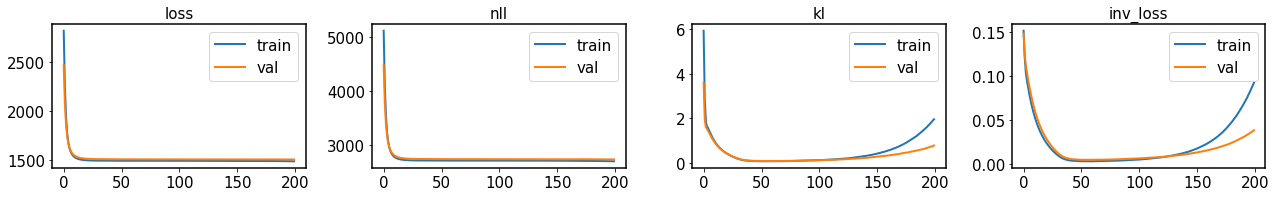

In [100]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [101]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()
x_denoised = inv_model.decode(z_sample, 
                      torch.ones_like(tensor_noises).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

In [102]:
big_noise_denoised = x_denoised[np.arange(n_noisy_nets)]
small_noise_denoised = x_denoised[np.arange(n_noisy_nets, n_nets)]
diff_noise_denoised = small_noise_denoised.mean(0) - big_noise_denoised.mean(0)

In [103]:
pca = PCA(2)
inv_vae_Xt = pca.fit_transform(inv_latents)
inv_vae_df = pd.DataFrame({"pc1": inv_vae_Xt[:,0], "pc2": inv_vae_Xt[:,1], "noise": noises})

plotting

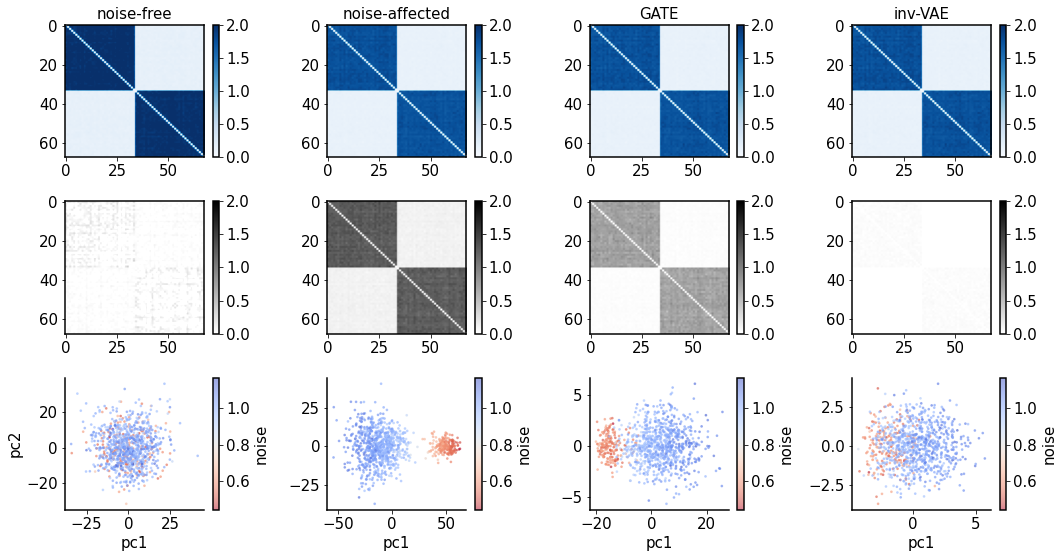

In [116]:
fig, axes = plt.subplots(3, 4, figsize=(15, 8))

p1 = axes[0,0].imshow(sim_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0,0].set_title('noise-free')
cbar = plt.colorbar(p1, ax=axes[0,0])

p2 = axes[1,0].imshow(diff_sim_nets, aspect='auto', cmap='binary', vmin=0, vmax=2)
cbar = plt.colorbar(p2, ax=axes[1,0])

p3 = axes[2,0].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm_r', data=sim_df, s=3, alpha=0.5)
axes[2,0].set_xlabel('pc1')
axes[2,0].set_ylabel('pc2')
axes[2,0].spines['top'].set_visible(False)
axes[2,0].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[2,0], label="noise")

p4 = axes[0,1].imshow(noisy_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0,1].set_title('noise-affected')
cbar = plt.colorbar(p4, ax=axes[0,1])

p5 = axes[1,1].imshow(diff_noise_nets, aspect='auto', cmap='binary', vmin=0, vmax=2)
cbar = plt.colorbar(p5, ax=axes[1,1])

p6 = axes[2,1].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm_r', data=noisy_df, s=3, alpha=0.5)
axes[2,1].set_xlabel('pc1')
axes[2,1].spines['top'].set_visible(False)
axes[2,1].spines['right'].set_visible(False)
cbar = plt.colorbar(p6, ax=axes[2,1], label="noise")

p7 = axes[0,2].imshow(x_recon.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0,2].set_title('GATE')
cbar = plt.colorbar(p7, ax=axes[0,2])

p8 = axes[1,2].imshow(diff_noise_recon, aspect='auto', cmap='binary', vmin=0, vmax=2)
cbar = plt.colorbar(p8, ax=axes[1,2])

p9 = axes[2,2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm_r', data=vae_df, s=3, alpha=0.5)
axes[2,2].set_xlabel('pc1')
axes[2,2].spines['top'].set_visible(False)
axes[2,2].spines['right'].set_visible(False)
cbar = plt.colorbar(p9, ax=axes[2,2], label="noise")

p10 = axes[0,3].imshow(x_denoised.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0,3].set_title('inv-VAE')
cbar = plt.colorbar(p10, ax=axes[0,3])

p11 = axes[1,3].imshow(diff_noise_denoised, aspect='auto', cmap='binary', vmin=0, vmax=2)
cbar = plt.colorbar(p11, ax=axes[1,3])

p12 = axes[2,3].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm_r', data=inv_vae_df, s=3, alpha=0.5)
axes[2,3].set_xlabel('pc1')
axes[2,3].spines['top'].set_visible(False)
axes[2,3].spines['right'].set_visible(False)
cbar = plt.colorbar(p12, ax=axes[2,3], label="noise")

plt.tight_layout()
plt.savefig('saved_figs/fig3_simulation.png', dpi=500)